# Information extraction from Cheshire fire incident reports using Mistral language model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4">Data preparation</a></span></li>
<li><span><a href="#EntityRecognizer-model" data-toc-modified-id="EntityRecognizer-model-5">EntityRecognizer model</a></span></li>
<ul class="toc-item">
<li><span><a href="#in-context-learning" data-toc-modified-id="In-context-learning">In-context learning</a></span>
<li><span><a href="#Evaluate-model-performance" data-toc-modified-id="Evaluate-model-performance-5.3">Evaluate model performance</a></span>
<li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-5.4">Validate results</a></span></li>
<li><span><a href="#Save-and-load-trained-models" data-toc-modified-id="Save-and-load-trained-models-5.5">Save and load trained models</a></span></li>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span></li>
<li><span><a href="#Publishing-the-results-as-feature-layer" data-toc-modified-id="Publishing-the-results-as-feature-layer-7">Publishing the results as feature layer</a></span></li>
<li><span><a href="#Visualize-crime-incident-on-map" data-toc-modified-id="Visualize-crime-incident-on-map- 8">Visualize crime incident on map</a></span></li>
<li><span><a href="#Create-a-hot-spot-map-of-crime-densities" data-toc-modified-id="Create-a-hot-spot-map-of-crime-densities-9">Create a hot spot map of crime densities</a></span></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10">Conclusion</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-11">References</a></span></li>
</ul></div>

## Introduction <a id="Introduction-1"></a>

As text data continues to grow rapidly, extracting meaningful insights from large amounts of information is more important than ever. Large language models (LLMs) have emerged as powerful tools for processing unstructured data, significantly enhancing the accuracy and efficiency of information extraction. One of the key tasks that can be performed using large language models is entity extraction, which involves identifying and classifying entities—such as names, organizations, locations, dates, and other specific details—within a text.

In this sample, we will explore how information extraction works using the Mistral language model in the `EntityRecognizer` class of the arcgis.learn API with the Cheshire fire incident reports dataset. The Cheshire fire dataset includes incident reports detailing fire incidents in Cheshire, covering information like locations, times, types of incidents, and response actions. This data can be valuable for analysis in understanding patterns, improving response strategies, and enhancing safety measures.

Key entities to extract from fire incident reports include:
- **Address**
- **Date and Time**
- **Incident Type**
- **Number of Engines**
- **Time Spent at Incident**



## Prerequisites

- Refer to the section **"Install Deep Learning Dependencies of arcgis.learn Module"** for detailed documentation on installing the dependencies: [Installation Guide](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies).
  
- Follow these steps to download and install the Mistral model backbone:
  
  1. Download the [Mistral Model Backbone](https://esri.maps.arcgis.com/home/item.html?id=969d2fc57c834295af1a4a42cfd51f68).
  2. Extract the downloaded zip file.
  3. Open the Anaconda Prompt and navigate to the folder that contains `arcgis_mistral_backbone-1.0.0-py_0.tar.bz2`.
  4. Run the following command:
     - ```conda install --offline arcgis_mistral_backbone-1.0.0-py_0.tar.bz2```

- To learn more about how `EntityRecognizer` works, please refer to the guide on [Named Entity Extraction Workflow with arcgis.learn](https://developers.arcgis.com/python/guide/how-named-entity-recognition-works/).


## Necessary Imports

In [1]:
import pandas as pd
import zipfile,unicodedata
from itertools import repeat
from pathlib import Path
from arcgis.gis import GIS
from arcgis.learn import prepare_textdata
from arcgis.learn.text import EntityRecognizer
from arcgis.geocoding import batch_geocode
import re
import os
import datetime

In [2]:
gis = GIS('home')

## Data preparation

Data preparation involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on.  The `prepare_data()` function can directly read the training samples in one of the above specified formats and automate the entire process.

<Item title:"information_extraction_from_cheshire_fire_incident_reports_using_mistral_language_model" type:Image Collection owner:api_data_owner>
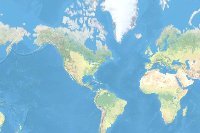

In [3]:
training_data = gis.content.get('ab3af7d1b8a24c1f8cc4e5bf3465d6bf')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [6]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
json_path = Path(os.path.join(os.path.splitext(filepath)[0] , 'cheshire_fire_incident_reports.json'))

In [1]:
os.path.splitext(filepath)[0]

In [9]:
data = prepare_textdata(path= json_path, task="entity_recognition", dataset_type='ner_json', class_mapping={'address_tag':'Address'})

In [10]:
data.show_batch()

,text,Address,Date_and_Time,Incident_Type,Number_of_Engines,Title,time_spent_at_incident
0,Industrial paper shredder fire in Widnes Time ...,"[Pickerings Road, Widnes]",[26/04/2018 - 21:07],[fire],[Two],[Industrial paper shredder fire in Widnes],[around half-an-hour]
1,Fire in field in Crewe Time of Incident: 07/03...,"[Vicarage Road, Crewe]",[07/03/2018 - 12:48],[fire],[One],[Fire in field in Crewe],
2,Car fire in Chester Time of Incident: 05/02/20...,"[Waverley Terrace, Chester]",[05/02/2018 - 22:26],[car fire],[One],[Car fire in Chester],
3,Industrial paper shredder fire in Widnes Time ...,"[Pickerings Road, Widnes]",[26/04/2018 - 21:07],[fire],[Two],[Industrial paper shredder fire in Widnes],[around half-an-hour]
4,Van fire in Chester Time of Incident: 05/10/20...,"[Christleton Road, Boughton, Chester]",[05/10/2018 - 10:45],[van fire],[One],[Van fire in Chester],
5,Industrial skip fire in Crewe Time of Incident...,"[Gresty Road, Crewe]",[27/11/2018 - 09:16],[fire],[Two],[Industrial skip fire in Crewe],[45 minutes]
6,Skip fire in Warrington Time of Incident: 25/1...,"[Griffiths Street, Warrington]",[25/10/2018 - 22:24],[skip fire],[One],[Skip fire in Warrington],
7,Fire at a dry cleaner's in Warrington Time of ...,"[Gaskell Street, Warrington]",[03/12/2018 - 17:14],[fire],[One],[Fire at a dry cleaner's in Warrington],[45 minutes]


## EntityRecognizer model

`EntityRecognizer` model in `arcgis.learn` can be used with [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) or with large language model backbones. For this sample use case we will use the Mistral model backbone to extract entities from the text.

Run the command below to see what backbones are supported for the **entity recognition** task.

In [11]:
print(EntityRecognizer.available_backbone_models("llm"))

('mistral',)


First we will create model using the `EntityRecognizer()` constructor and passing the following parameter:

<code>data</code>: The databunch created using the <i>prepare_textdata</i> method.

<code>backbone</code>: To use mistral as the model backbone, use <i>backbone="mistral"</i>.

<code>prompt</code>: Text string describing the task and its guardrails. This is an optional parameter.

In [12]:
ner = EntityRecognizer(data,
                       backbone="mistral",
                       prompt="Tag the input sentences in the named entity for the given classes, no other class should be tagged."
                      )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The Mistral model will automatically infer the classes from the dataset. The list of inferred class names is as follows:

- Address  
- Date_and_Time  
- Incident_Type  
- Number_of_Engines  
- Title  
- Time_spent_at_incident 

## In-context learning

The Mistral model utilizes in-context learning to generate predictions. Unlike traditional models that depend on lengthy training cycles, it can understand the task using just a few examples and a prompt. By incorporating this information into the input, the Mistral model gains a better understanding and can make more accurate predictions without needing retraining.

## Evaluate model performance

Important metrics to look at while measuring the performance of the `EntityRecognizer` model are **Precision**, **Recall** & **F1-measures** 

In [13]:
ner.precision_score()

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


0.7

In [14]:
ner.recall_score()

0.64

In [15]:
ner.f1_score()

0.66

To find **precision**, **recall** & **f1** scores per label/class we will call the model's `metrics_per_label()` method.

In [16]:
ner.metrics_per_label()

,Precision_score,Recall_score,F1_score
time_spent_at_incident,0.17,0.20,0.18
address,0.00,0.00,0.00
incident_type,1.00,0.67,0.80
o,0.71,0.91,0.80
date_and_time,1.00,0.90,0.95
number_of_engines,1.00,0.90,0.95
title,1.00,0.90,0.95


## Validate results

Now we have the trained model, let's look at how the model performs.

In [17]:
ner.show_results()

,TEXT,address,time_spent_at_incident,incident_type,title,number_of_engines,date_and_time
0,Fire in the open at a farm in Chester Time of...,"harthill lane, chester",1 hour and a half,fire in the open,fire in the open at a farm in chester,one,06/08/2018-14:29
1,Car fire in Northwich Time of Incident: 22/08...,"walnut avenue, northwich",,car fire,car fire in northwich,one,22/08/2018-20:39
2,Grassland fire in Macclesfield Time of Incide...,"hooleyhey lane, macclesfield",,grassland fire,grassland fire in macclesfield,one,02/07/2018-13:55
3,"Tree fire, Warrington Time of Incident: 24/02...","off shackleton close, warrington",,tree fire,"tree fire, warrington",one,24/02/2018-14:38
4,Explosion at a house in Warrington Time of In...,"heath lane, warrington",2 hours 40 minutes,explosion,explosion at a house in warrington,three,28/09/2018-15:01
5,Digger fire in Warrington Time of Incident: 0...,"manchester road, warrington",,digger fire,digger fire in warrington,two,07/12/2018-20:19
6,Small fire in a garden in Warrington Time of ...,"waterside, warrington",around half-an-hour,fire,small fire in a garden in warrington,one,05/08/2018 - 18:14
7,Fire involving rubbish in Warrington Time of ...,"bridge lane, warrington",around 20 minutes,fire,fire involving rubbish in warrington,one,18/05/2018-08:29
8,Small fire in the open in Warrington Time of ...,"parkfields lane, poulton-with-fearnhead, warri...",20 minutes,fire,small fire in the open in warrington,one,25/07/2018-19:01
9,Greenhouse fire in Widnes Time of Incident: 1...,"scott avenue, widnes",,greenhouse fire,greenhouse fire in widnes,one,10/05/2018-18:52


## Save and load trained models

Once you are satisfied with the model, you can save it using the `save()` method. This creates an Esri Model Definition (EMD file) that can be used for inferencing on new data. 
Saved models can also be loaded back using the `load()` method. `load()` method takes the path to the emd file as a required argument.

In [18]:
ner.save('cheshire_fire_model')

Computing model metrics...
Model has been saved to C:\Users\sur11226\AppData\Local\Temp\information_extraction_from_cheshire_fire_incident_reports_using_mistral_language_model\models\cheshire_fire_model


## Model Inference

Now we can use the trained model to extract entities from new text documents using `extract_entities()` method. This method expects the folder path of where new text document are located, or a list of text documents.

In [20]:
reports = os.path.join(os.path.splitext(filepath)[0] , 'reports')

In [24]:
item_names = os.listdir(reports)

In [26]:
# item_names

In [31]:
reports_list = []
file_encoding="utf-8"
for filename in item_names:
    file_path = os.path.join(reports, filename)
    ext = os.path.splitext(filename)[-1].lower().replace(".", "")
    if ext == "txt":
        with open(file_path, "r", encoding=file_encoding, errors="ignore") as f:
            reports_list.append(f.read())

In [32]:
results = ner.extract_entities(reports_list)

In [33]:
results.head()

,TEXT,address,time_spent_at_incident,incident_type,title,number_of_engines,date_and_time,Filename
0,Person stuck in lift in Neston Time of Inciden...,"brook street, neston",,person in lift,person stuck in lift in neston,one,30/01/2015 - 16:36,Example_0
1,Arson investigation after fire in Crewe Time o...,"charlesworth street, crewe",,fire,arson investigation after fire in crewe,two,28/01/2015-23:09,Example_1
2,Grill pan fire in Macclesfield Time of Inciden...,"buxton road, macclesford",,grill pan fire,grill pan fire in macclesfield,one,03/01/2015 - 13:07,Example_2
3,Collision involving car and HGV on M6 Time of ...,"m6 north, j20",,collision,collision involving car and hgv on m6,"two,one",28/01/2015-22:49,Example_3
4,Road traffic collision in Macclesfield Time of...,"congleton road, gawsworth, macclesfield",n/a,road traffic collision,road traffic collision in macclesfield,"one,one",28/01/2015-17:36,Example_4


## Conclusion

This sample demonstrates how `EntityRecognizer()` from `arcgis.learn` can be used for information extraction from Cheshire fie incident reports using the Mistral large language model.

## References
Mistral-7B HuggingFace: <a href="https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2">https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2</a><br/>
Mistral-7B MistralAI: <a href="https://mistral.ai/news/announcing-mistral-7b/">https://mistral.ai/news/announcing-mistral-7b</a>